# Simple GP example

[ 2.79875601e-08 -5.73219565e-07 -1.60975263e-07  1.97339004e-07
  2.53658111e-07  1.04334725e-07 -8.07461499e-08 -1.83632640e-07
 -1.70286449e-07 -7.21681220e-08  4.91293509e-08  1.36041934e-07
  1.56941332e-07  1.11322628e-07  2.45976545e-08 -6.64892293e-08
 -1.27554957e-07 -1.38692335e-07 -9.92678936e-08 -2.57493259e-08
  5.46730211e-08  1.14163293e-07  1.32968678e-07  1.05714028e-07
  4.22071945e-08 -3.56962361e-08 -1.01369114e-07 -1.32299321e-07
 -1.17460382e-07 -6.08208017e-08  1.88895777e-08  9.42445677e-08
  1.37127524e-07  1.30326999e-07  7.24790159e-08 -1.75966185e-08
 -1.06161534e-07 -1.55622614e-07 -1.39315567e-07 -5.56910934e-08
  6.53638997e-08  1.66829112e-07  1.85242777e-07  8.64049173e-08
 -9.84021904e-08 -2.51633338e-07 -2.00648957e-07  1.57054447e-07
  5.77414292e-07 -2.67632849e-08]


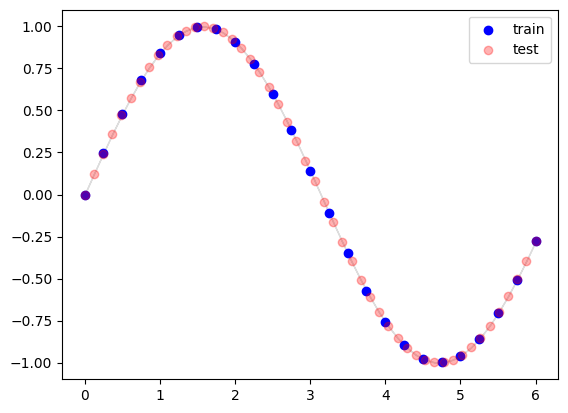

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ichor.core.models.kernels.distance import Distance

def se_kernel(a, b, sigma,l):
    """definition of SE kernel with lengthscale and variance"""
    dist2 = Distance.squared_euclidean_distance(a, b)

    return sigma**2*np.exp(-dist2/(2*l**2))

train_x = np.linspace(0, 6, 25).reshape(-1,1)
train_y = np.sin(train_x)
test_x = np.linspace(0, 6, 50).reshape(-1,1)
test_x_true = np.sin(test_x)

ntrain = train_x.shape[0]

mu = 0.0
LENGTHSCALE = 2.0
OUTPUTSCALE = 1.0
NOISE = 1e-12 * np.eye(ntrain)

K = se_kernel(train_x, train_x, OUTPUTSCALE, LENGTHSCALE) + NOISE # n_train x n_train with noise on diagonal
K_s = se_kernel(test_x, train_x, OUTPUTSCALE, LENGTHSCALE) # ntest x n_train
K_ss = se_kernel(test_x, test_x, OUTPUTSCALE, LENGTHSCALE) # n_test x n_test

L = np.linalg.cholesky(K)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_y)) # weights
v = np.linalg.solve(L, K_s.T) # temp vector to calculate variance

predictions = (mu + np.matmul(K_s, alpha)).flatten()
posterior_covariance = K_ss - np.dot(v.T, v)
var = np.diag(posterior_covariance)
stdv = np.sqrt(var)

errors = test_x_true.flatten() - predictions

plt.gca().fill_between(test_x.flatten(), predictions-2*stdv, predictions+2*stdv, color="#dddddd") # 2 sigma confidence interval
# plt.plot(train_x, train_y)
plt.scatter(train_x, train_y, color="b", label="train")
plt.scatter(test_x, predictions, color="r", label="test", alpha=0.3)
plt.legend()
plt.show()